# Clustering: k-means and GMM

-----------------------------------------

## Project Guide
- [Building Cluster Assignment Algorithms](#Building-Cluster-Assignment-Algorithms)
- [Building Cluster Update Functions](#Building-Cluster-Update-Functions)
- [Clustering in sklearn](#Clustering-in-sklearn)

## Project Overview

------------------------

#### EXPECTED TIME 2.5 HRS

Clustering algorithms are mostly straightforward: Points are assigned to centroids, and centroids are updated --- repeat until convergence.  

Much of the difficulty in *using* clustering involves picking how many centroids to create and  how to initialize those centroids.  For the purposes of this assignment, focus will remain on the particulars of the algorithms.  
You will be asked to code functions implementing k-means, soft k-means, and GMM clustering. This includes:

- Assigning points (or parts of points) to clusters
- Recalculating cluster / cluster centers.

**Data:** For this exercise, (derived) data in two dimensions will be used. In four differend instances, three clusters of data were derived from three different distributions. Sometimes the distributions overlap, other times they're more separated.  

See the below visualization for the four different sets of distributions.  

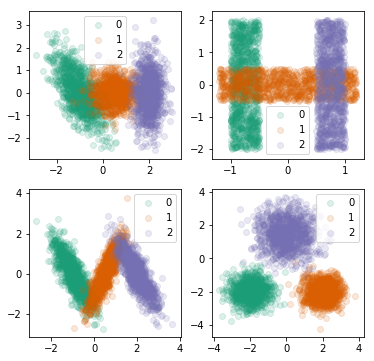

In [1]:
from scipy.stats import multivariate_normal
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

# File Paths
mv_path = "../resource/asnlib/publicdata/mv.csv"
unif_path = "../resource/asnlib/publicdata/unif.csv"
mv2_path = "../resource/asnlib/publicdata/mv2.csv"
mv3_path = "../resource/asnlib/publicdata/mv3.csv"

# Read in Data
mv_df = pd.read_csv(mv_path, index_col = 0)
unif_df = pd.read_csv(unif_path, index_col = 0)
mv2_df = pd.read_csv(mv2_path, index_col = 0)
mv3_df = pd.read_csv(mv3_path, index_col = 0)

# Create Figure
fig, (axs) = plt.subplots(2,2, figsize = (6,6))

# Plot each group in each dataset as unique olor
for ax, df in zip(axs.flatten(), [mv_df, unif_df, mv2_df, mv3_df]):
    for cat, col in zip(df['cat'].unique(), ["#1b9e77", "#d95f02", "#7570b3"]):
        ax.scatter(df[df.cat == cat].x, df[df.cat == cat].y, c = col, label = cat, alpha = .15)
    ax.legend()

As such each centroid will be defined by an $(x,y)$ pair of coordinates. The clusters for the GMM model will also have a $2x2$ covariance matrix and a $\pi$ term.  

In the case of GMM models, each cluster center will be initialized with $\pi = \frac1k$  where $k$ is the number of clusters; and $\Sigma = \begin{bmatrix}
    1 & 0\\
    0&1
\end{bmatrix}$  


To initialize the clusters, a K-means++ type algorithm will be used.

K-means++ picks one point from the data to be the first cluster center. Subsequent cluster centers are picked from the remaining "unpicked" points. However, the probability of picking any one point is proportional to the euclidean distance from that point to the nearest cluster center squared.  

In [2]:
# Implement K-means ++ to initialize centers

def pick_cluster_centers(points, num_clusters = 3):
    # Create List to store clusters
    clusters = []
    
    # Save list of cluster indicies
    arr_idx = np.arange(len(points))
    
    # Choose first cluster; append to list
    clusters.append( points[np.random.choice(arr_idx)])
    
    # Define function to calculate squared distance
    def dist_sq(x): return np.linalg.norm(x)**2
    
    c_dist = None

    # Add Clusters until reaching "num_clusters"
    while len(clusters) < num_clusters:
        
        # Calculate distance between latest cluster and rest of points
        new_dist = np.apply_along_axis(np.linalg.norm, 1, points - clusters[-1]).reshape(-1,1)
        
        # Add to distance array - First check to see if distance matrix exists
        if type(c_dist) == type(None):
            c_dist = new_dist
            
        else:
            c_dist = np.concatenate([c_dist, new_dist], axis = 1)
        
        # Calculate probability by finding shortest distance, then normalizing
        c_prob = np.apply_along_axis(np.min, 1, c_dist)
        c_prob = c_prob / c_prob.sum()

        # Draw new cluster according to probability
        clusters.append(points[np.random.choice(arr_idx, p = c_prob)])
            
    return np.array(clusters)

# Function to add pi and Sigma for GMM clusters
def build_GMM_clusters(clusters):
    return [(c, 1/len(clusters), np.array([[1,0],[0,1]])) for c in clusters]

#### Method of Describing Cluster Assignments
In hard clustering (only k-means in this assignment), each point is assigned exclusively to one cluster. In soft clustering (soft k-means and GMM), points may be portioned out between clusters.  

Thus, for this assignment, allocation of points to clusters will be stored in a 2-d numpy array. Assume for the following examples that there are three clusters.  

In k-means, if a point were assigned to cluster "0", its cluster assignment would be `[1,0,0]`. In the soft clustering, if the point were split evenly between the three clusters, it's cluster assignment would be `[.33,.33,.33]`.  

If there were three points, and two clusters, with k-means, the cluster-matrix might be:  

`np.array([[1,0],[1,0],[0,1]])` In this case, the first two points are assigned to cluster "0" and the third point is assigned to cluster "1".  

Note: the `np.apply_along_axis` function can be useful in these exercises.  

### Building Cluster Assignment Algorithms

#### Question 1

For the point $i$; set cluster indicator $c_i$ to be the $k$ according to the equation $c_i =\text{argmin}_k\ ||x_i - \mu_k||^2$, where $k$ is one of the clusters.

e.g. The point $i$ is in the cluster with the center nearest to the point.

Code a function called `assign_clusters_k_means`
Accept two arguments:  

- points: a 2-d `numpy` array of the locations of each point
- clusters: a 2-d `numpy` array of the locations of the centroid of each cluster.

Determine which cluster centroid is closest to each point.

RETURN a 2-d `numpy` array where each row indicates which cluster a point is closets to, and thus also assigned to:  

e.g. [0,1,0,...,0] indicates the point is assigned to the second cluster, and  
[0,0,...,1] indicates the point is assigned to the last cluster

In [3]:
from scipy.spatial import distance
# dst = distance.euclidean(a, b)

In [41]:
### GRADED

### Assign points to clusters according to the k-means algorithm
### Follow directions above

### YOUR ANSWER BELOW

def assign_clusters_k_means(points, clusters):
    """
    Determine the nearest cluster to each point, returning an array indicating the closest cluster
    
    Positional Arguments:
        points: a 2-d numpy array where each row is a different point, and each
            column indicates the location of that point in that dimension
        clusters: a 2-d numpy array where each row is a different centroid cluster;
            each column indicates the location of that centroid in that dimension
    
    Example:
        points = np.array([[0,1], [2,2], [5,4], [3,6], [4,2]])
        clusters = np.array([[0,1],[5,4]])
        cluster_weights = assign_clusters_k_means(points, clusters)
        
        print(cluster_weights) #--> np.array([[1, 0],
                                              [1, 0],
                                              [0, 1],
                                              [0, 1],
                                              [0, 1]])
    """
    # NB: "cluster_weights" is used as a common term between functions
    # the name makes more sense in soft-clustering contexts
    
    
    distances = np.concatenate([np.apply_along_axis(np.linalg.norm, 1, points - c).reshape(-1, 1) for c in clusters], axis =1)
    
    def find_min(x):
        mini = np.min(x)
        return [1 if n == mini else 0 for n in x]

    cluster_solution = np.apply_along_axis(find_min, 1, distances)
            
    return cluster_solution

In [44]:
points = np.array([[0,1], [2,2], [5,4], [3,6], [4,2]])
clusters = np.array([[0,1],[5,4]])
cluster_weights = assign_clusters_k_means(points, clusters)
        
print(cluster_weights)

[[1 0]
 [1 0]
 [0 1]
 [0 1]
 [0 1]]


In [ ]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


#### Question 2
Code a function called `assign_clusters_soft_k_means`

Accept three arguments:  

- points: a 2-d `numpy` array of the locations of each point
- clusters: a 2-d `numpy` array of the locations of the centroid of each cluster
- beta: numeric - corresponding to what distance should be considered "close" 


RETURN a 2-d numpy array of cluster weights where each row indicates the poportion of the corresponding point belonging to every cluster.  

e.g. If a point "belongs" evenly to both of the two clusters, the row would be: [.5,.5].  


The proportion of a point $i$ that belongs to cluster $k$ is defined by the $\phi$ function for weighted k-means: 
$$\phi_i(k) = \frac{exp\{-\frac1\beta||x_i-\mu_k||^2\}}{\sum_jexp\{-\frac1\beta||x_i-\mu_j||^2\}}$$  


In [52]:
### GRADED
### Follow directions above

### YOUR ANSWER BELOW

def assign_clusters_soft_k_means(points, clusters, beta):
    
    """
    Return an array indicating the porportion of the point
        belonging to each cluster
    
    Positional Arguments:
        points: a 2-d numpy array where each row is a different point, and each
            column indicates the location of that point in that dimension
        clusters: a 2-d numpy array where each row is a different centroid cluster;
            each column indicates the location of that centroid in that dimension
        beta: a number indicating what distance can be considered "close"
        
    Example:
        points = np.array([[0,1], [2,2], [5,4], [3,6], [4,2]])
        clusters = np.array([[0,1],[5,4]])
        beta = 1
        cluster_weights = assign_clusters_soft_k_means(points, clusters, beta)
        
        print(cluster_weights) #--> np.array([[0.99707331, 0.00292669],
                                              [0.79729666, 0.20270334],
                                              [0.00292669, 0.99707331],
                                              [0.04731194, 0.95268806],
                                              [0.1315826 , 0.8684174 ]])
    """
    
    def exponent(x):
        return np.exp((-1/beta) * np.linalg.norm(x))
    
    weights = np.concatenate([np.apply_along_axis(exponent, 1, points - c).reshape(-1, 1) for c in clusters], axis =1)
    
    def normalize_weights(x):
        return [n/np.sum(x) for n in x]
    
    weights = np.apply_along_axis(normalize_weights, 1, weights)
    
    return weights

In [ ]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


In [53]:
points = np.array([[0,1], [2,2], [5,4], [3,6], [4,2]])
clusters = np.array([[0,1],[5,4]])
beta = 1

cluster_weights = assign_clusters_soft_k_means(points, clusters, beta)
print(cluster_weights)

[[0.99707331 0.00292669]
 [0.79729666 0.20270334]
 [0.00292669 0.99707331]
 [0.04731194 0.95268806]
 [0.1315826  0.8684174 ]]


#### Question 3
Code a function called `assign_clusters_GMM`

Accept two arguments:  

- points: a 2-d `numpy` array of the locations of each point
- clusters: a list of tuples. The $k^{th}$ tuple in the list contains $(\mu_k, \pi_k, \Sigma_k)$ corresponding cluster k. See below for further example.


RETURN a 2-d numpy array of cluster weights where each row indicates the poportion of the corresponding point belonging to every cluster.  

e.g. If a point "belongs" evenly to both of the two clusters, the row would be: [.5,.5].   



The proportion of a point $i$ that belongs to cluster $k$ is defined by the $\phi$ function for GMM:  

$$\phi_i(k) = \frac{\pi_k N(x_i|\mu_k,\Sigma_k)}{\sum_j \pi_j N(x_i|\mu_j,\Sigma_k)}$$ 

Note, $N(x_i|\mu_k,\Sigma_k)$ maybe found with `stats.multivariate_normal(mu,Sigma).pdf(x)` 

The `clusters` input will be a list of tuples. The tuples will be organized:  
($\mu$, $\pi$, $\Sigma$)
Where $\mu$ is a 1-d numpy array; $\pi$ is numeric, and $\Sigma$ is 2-d numpy array.

E.g. for $i = 0$ and $k = 0$:  

    c = clusters[0]
    p = points[0]
    stats.multivariate_normal(c[0],c[2]).pdf(x)


In [66]:
### GRADED
### Follow directions above

### YOUR ANSWER BELOW

def assign_clusters_GMM(points, clusters):
    """    
    Return an array indicating the porportion of the point
        belonging to each cluster
    
    Positional Arguments:
        points: a 2-d numpy array where each row is a different point, and each
            column indicates the location of that point in that dimension
        clusters: a list of tuples. Each tuple describes a cluster.
            The first element of the tuple is a 1-d numpy array indicating the
                location of that centroid in each dimension
            The second element of the tuple is a number, indicating the weight (pi)
                of that cluster
            The thrid element is a 2-d numpy array corresponding to that cluster's
                covariance matrix.
        
    Example:
        points = np.array([[0,1], [2,2], [5,4], [3,6], [4,2]])
        clusters = [(np.array([0,1]), 1, np.array([[1,0],[0,1]])),
                    (np.array([5,4]), 1, np.array([[1,0],[0,1]]))]
        
        cluster_weights = assign_clusters_GMM(points, clusters)
        
        print(cluster_weights) #--> np.array([[9.99999959e-01 4.13993755e-08]
                                              [9.82013790e-01 1.79862100e-02]
                                              [4.13993755e-08 9.99999959e-01]
                                              [2.26032430e-06 9.99997740e-01]
                                              [2.47262316e-03 9.97527377e-01]])
    """
    
    def pdf_fun(mu, pi, sigma):
        return lambda x: pi*stats.multivariate_normal(mu, sigma).pdf(x)
    
    weights = []
    
    for clus in clusters:
        pdf = pdf_fun(*clus)
        
        weights.append(np.apply_along_axis(pdf, 1, points).reshape(-1, 1))
        
    weights = np.concatenate(weights, axis =1)
    def norm_clusts(x):
        return [n/np.sum(x) for n in x]
    
    cluster_assigment = np.apply_along_axis(norm_clusts, 1, weights)
    
    return cluster_assigment

In [ ]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


In [67]:
points = np.array([[0,1], [2,2], [5,4], [3,6], [4,2]])
clusters = [(np.array([0,1]), 1, np.array([[1,0],[0,1]])),
                    (np.array([5,4]), 1, np.array([[1,0],[0,1]]))]
        
cluster_weights = assign_clusters_GMM(points, clusters)
        
print(cluster_weights)

[[9.99999959e-01 4.13993755e-08]
 [9.82013790e-01 1.79862100e-02]
 [4.13993755e-08 9.99999959e-01]
 [2.26032430e-06 9.99997740e-01]
 [2.47262316e-03 9.97527377e-01]]


### Building Cluster Update Functions
#### Question 4

Code a function called `upadate_clusters_k_means`

ACCEPT two inputs:  
- points: a 2-d numpy array of the locations of each point
- cluster_weights: a 2-d numpy array indicating cluster assignment for each point

RETURN a 2-d numpy array giving the new locations of the centroid for each cluster.  

The centroid for cluster $k$ ($\mu_k$) should be updated with the equation:  

$$\mu_k = \frac{\sum_ix_i\mathbb{1}\{c_i = k\}}{\sum_i\mathbb{1}\{c_i = k\}}$$

- $c_i$ indicates to which cluster point $i$ was assigned  
- Generally, the new centroids are the center (mean) of all points associated with the cluster

Each row of `cluster_weights` contains a single "1", otherwise filled with "0"s. e.g. if point $i$ is assigned to the first cluster (cluster "0"), the row corresponding to $i$ in `cluster_weights` will be [1,0,0,...,0].  

In [129]:
### GRADED
### Follow directions above

### YOUR ANSWER BELOW

def update_clusters_k_means(points, cluster_weights):
    
    """
    Update the cluster centroids via the k-means algorithm
    
    Positional Arguments -- 
        points: a 2-d numpy array where each row is a different point, and each
            column indicates the location of that point in that dimension
        cluster_weights: a 2-d numy array where each row corresponds to each row in "points"
            and the columns indicate which cluster the point "belongs" to - a "1" in the kth
            column indicates belonging to the kth cluster
            
    Example:
    
        points = np.array([[0,1], [2,2], [5,4], [3,6], [4,2]])
        cluster_weights = np.array([[1, 0],[1, 0],[0, 1],[0, 1],[0, 1]])
        
        new_cents = update_clusters_k_means(points, cluster_weights)
        
        print(new_cents) #--> np.array([[1. , 1.5],
                                        [4. , 4. ]])
    
    """
    new_clusts = []
    
    for c in cluster_weights.T:
        c_points = points.copy()[c ==1, :]
    
        new_clusts.append(np.apply_along_axis(np.mean, 0, c_points))
    
    return np.array(new_clusts)

In [ ]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


In [130]:
testit = update_clusters_k_means(points, cluster_weights)

In [132]:
testit

array([[1. , 1.5],
       [4. , 4. ]])

In [120]:
points = np.array([[0,1], [2,2], [5,4], [3,6], [4,2]])
cluster_weights = np.array([[1, 0],[1, 0],[0, 1],[0, 1],[0, 1]])
new_cents = update_clusters_k_means(points, cluster_weights) 

print(new_cents)

[array([1. , 1.5]), array([4., 4.])]


In [114]:
new_clusts = []

for c in cluster_weights.T:
        c_points = points.copy()[c ==1, :]
        new_clusts.append(np.apply_along_axis(np.mean, 0, c_points))

In [106]:
new_clusts = []
new_clusts.append(np.apply_along_axis(np.mean, 0, c_points))

In [122]:
new_clusts[0]

array([1. , 1.5])

In [118]:
new_clusts[1]

array([4., 4.])

#### Question 5

Code a function called `upadate_clusters_soft_k_means`

ACCEPT two input:  
- points: a 2-d numpy array of the locations of each point
- cluster_weights: a 2-d numpy array indicating cluster assignment for each point

RETURN a 2-d numpy array giving the new locations of the centroid for each cluster.  

The centroid for cluster $k$ ($\mu_k$) should be updated with the equation:  

$$\mu_k = \frac{\sum_ix_i\phi_i(k)}{\sum_i\phi_i(k)}$$  

Each row of `cluster_weights` is $k$ numeric weights corresponding to the $k$ clusters($\phi_i(k)$). Each row adds up to one. e.g. if point $i$ is assigned evenly to the two clusters, the row corresponding to $i$ in `cluster_weights` will be [.5,.5]. Thus $\phi_i(0) = .5 \text{ and }\phi_i(1) = .5$  

In [86]:
### GRADED
### Follow directions above

### YOUR ANSWER BELOW
def update_clusters_soft_k_means(points, cluster_weights):
    
    """
    Update cluster centroids according to the soft k-means algorithm
    
    Positional Arguments --
        points: a 2-d numpy array where each row is a different point, and each
            column indicates the location of that point in that dimension
        cluster_weights: a 2-d numpy array where each row corresponds to each row in 
            "points". the values in that row corresponding to the amount that point is associated
            with each cluster.
            
    Example --
        points = np.array([[0,1], [2,2], [5,4], [3,6], [4,2]])

        cluster_weights= np.array([[0.99707331, 0.00292669],
                                   [0.79729666, 0.20270334],
                                   [0.00292669, 0.99707331],
                                   [0.04731194, 0.95268806],
                                   [0.1315826 , 0.8684174 ]])
        centroids = update_clusters_soft_k_means(points, cluster_weights)
        
        print(centroids) #--> np. array([[1.15246591, 1.59418291],
                                         [3.87673553, 3.91876291]])
    """
    new_clusts = []
    for c in cluster_weights.T:
        cw_sum = np.apply_along_axis(np.sum, 0, c)
        
        new_c = np.apply_along_axis(np.sum, 0, points*c.reshape(-1, 1))/cw_sum
        new_clusts.append(new_c.reshape(1, -1))
        
    new_centroids = np.concatenate(new_clusts)
    
    return new_centroids

In [ ]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


In [87]:
points = np.array([[0,1], [2,2], [5,4], [3,6], [4,2]])

cluster_weights= np.array([[0.99707331, 0.00292669],
                                   [0.79729666, 0.20270334],
                                   [0.00292669, 0.99707331],
                                   [0.04731194, 0.95268806],
                                   [0.1315826 , 0.8684174 ]])
centroids = update_clusters_soft_k_means(points, cluster_weights)
        
centroids

array([[1.15246591, 1.59418291],
       [3.87673553, 3.91876291]])

#### Question 6

Code a function called `upadate_clusters_GMM`

ACCEPT two input:  
- points: a 2-d numpy array of the locations of each point
- cluster_weights: a 2-d numpy array indicating cluster assignment for each point

RETURN a list of tuples, giving the updated parameters each cluster. Tuple for cluster $k$ will be ($\mu_k$, $\pi_k$, $\Sigma_k$).  
$\mu_k$ should be a numpy array (vector) of length d.  
$\pi_k$ should be a float  
$\Sigma_k$ should be a numpy array (matrix) of size d x d  


The parameters are updated according to the following---  
FOR $\pi_k$:
$$\pi_k = \frac{n_k}{n}\ \text{  WHERE  }\ n_k=\sum\limits_{i=1}^n\phi_i(k)$$


FOR $\mu_k$:
$$\mu_k = \frac1{n_k}\sum\limits_{i=1}^n \phi_i(k)x_i$$

AFTER UPDATING $\mu_k$:
$$\Sigma_k = \frac1{n_k}\sum\limits_{i=1}^n\phi_i(k)(x_i-\mu_k)(x_i-\mu_k)^T$$

Each row of `cluster_weights` is $k$ numeric weights corresponding to the $k$ clusters($\phi_i(k)$). Each row adds up to one. e.g. if point $i$ is assigned evenly to the two clusters, the row corresponding to $i$ in `cluster_weights` will be [.5,.5]. Thus $\phi_i(0) = .5 \text{ and }\phi_i(1) = .5$  

In [91]:
### GRADED
### Follow directions above

### YOUR ANSWER BELOW

def update_clusters_GMM(points, cluster_weights):
    
    """
    Update cluster centroids (mu, pi, and Sigma) according to GMM formulas
    
    Positional Arguments --
        points: a 2-d numpy array where each row is a different point, and each
            column indicates the location of that point in that dimension
        cluster_weights: a 2-d numpy array where each row corresponds to each row in 
            "points". the values in that row correspond to the amount that point is associated
            with each cluster.
    Example --
        points = np.array([[0,1], [2,2], [5,4], [3,6], [4,2]])
        cluster_weights = np.array([[9.99999959e-01, 4.13993755e-08],
                                    [9.82013790e-01, 1.79862100e-02],
                                    [4.13993755e-08, 9.99999959e-01],
                                    [2.26032430e-06, 9.99997740e-01],
                                    [2.47262316e-03, 9.97527377e-01]])

        new_clusters = update_clusters_GMM(points, cluster_weights)
        
        print(new_clusters)
            #-->[(array([0.99467691, 1.49609648]), #----> mu, centroid 1
                0.3968977347767351, #-------------------> pi, centroid 1
                array([[1.00994319, 0.50123508],
                       [0.50123508, 0.25000767]])), #---> Sigma, centroid 1
                
                (array([3.98807155, 3.98970927]), #----> mu, centroid 2
                0.603102265479875, #-------------------> pi, centroid 2
                array([[ 0.68695286, -0.63950027], #---> Sigma centroid 2
                       [-0.63950027,  2.67341935]]))]
        
    """
    new_clusts = []
    for c in cluster_weights.T:
        n_k = np.sum(c)
        
        pi_k = n_k/len(points)
        
        mu_k = np.apply_along_axis(np.sum, 0, points * c.reshape(-1, 1))/ n_k
        
        sigma_k = 0
        
        for cw, point in zip(c, points):
            
            diff = point - mu_k
            
            sigma_k += cw * diff.reshape(-1 ,1)@diff.reshape(1, -1)
            
        sigma_k = sigma_k / n_k
            
        new_c = (mu_k, pi_k, sigma_k)
            
        new_clusts.append(new_c)
            
    return new_clusts

In [ ]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


In [92]:
points = np.array([[0,1], [2,2], [5,4], [3,6], [4,2]])
cluster_weights = np.array([[9.99999959e-01, 4.13993755e-08],
                                    [9.82013790e-01, 1.79862100e-02],
                                    [4.13993755e-08, 9.99999959e-01],
                                    [2.26032430e-06, 9.99997740e-01],
                                    [2.47262316e-03, 9.97527377e-01]])

new_clusters = update_clusters_GMM(points, cluster_weights)
        
print(new_clusters)

[(array([0.99467691, 1.49609648]), 0.3968977347767351, array([[1.00994319, 0.50123508],
       [0.50123508, 0.25000767]])), (array([3.98807155, 3.98970927]), 0.603102265479875, array([[ 0.68695286, -0.63950027],
       [-0.63950027,  2.67341935]]))]


### Clustering in sklearn

With all the cluster assignment and centroid updating functions defined, we can now test the clustering functionality on our derived data.  

In the cells below, a number of functions are defined.  

- Create meta-function which can combine the "assign" and "update" functions into a coherent clustering algorithm with stopping thresholds
- Create k-means, GMM and soft k-means functions
- Create plotting function to compare `sklearn` and custom k-menas algorithms  
    - The assignment of initial clusters will be determined by the `pick_cluster_centers` function defined above, with centers passed explicitly to the custom algorithm and `sklearn` algorithm. 

NB: Soft k-means is not implemented in `sklearn`, and the custom GMM function will take too much processing time for Vocareum.

In [93]:
# Create function that will create clustering functions
def create_cluster_func(assign_func, update_func, threshold_func, assign_args = {}):
    
    def cluster(points, centroids, max_iter = 100, stop_threshold = .001):
        for i in range(max_iter):
            old_centroids = centroids
            
            cluster_weights = assign_func(points, centroids, **assign_args)
            centroids = update_func(points, cluster_weights)
            
            if threshold_func(centroids, old_centroids, stop_threshold):
                break
        
        return centroids
    return cluster

# Create functions that test for convergence
def basic_threshold_test(centroids, old_centroids, stop_threshold):
    
    for n, o in zip(centroids, old_centroids):
        #print(n,o)
        if np.linalg.norm(n-o) > stop_threshold:
            return False
    return True

def GMM_threshold_test(centroids, old_centroids, stop_threshold):
    for np, op in zip(centroids, old_centroids):
        if not basic_threshold_test(np,op,stop_threshold):
            return False
    return True

In [94]:
### Creating actual functions for clustering
cluster_k_means = create_cluster_func(assign_clusters_k_means,
                                      update_clusters_k_means,
                                      basic_threshold_test)

# Below provided for experimentation only. 

cluster_GMM = create_cluster_func(assign_clusters_GMM,
                                  update_clusters_GMM,
                                  GMM_threshold_test)


cluster_soft_k_means = create_cluster_func(assign_clusters_soft_k_means,
                                           update_clusters_soft_k_means,
                                           basic_threshold_test,
                                           {'beta':.3}) # This is where the "beta" parameter may be changed

In [96]:
# Visualization function for k-means
from sklearn.cluster import  KMeans


def plot_k_means(clusters = 3):
    # Create figure
    fig, (axs) = plt.subplots(2,2, figsize = (6,6))
    
    # Go thorugh all data sets 
    for ax, df in zip(axs.flatten(), [mv_df, unif_df, mv2_df, mv3_df]):
        
        # Pull out point data
        points = df.iloc[:,:2].values
        
        # Pick random initial centers
        init_cents = pick_cluster_centers(points, clusters)
        
        # Calculate centers from custom function
        cents = cluster_k_means(points ,init_cents)
        
        # Calculate centers from sklearn
        km = KMeans(n_clusters= clusters, init = init_cents, n_init=1).fit(points)
        cent_sk = km.cluster_centers_
        
        # Plot each distribution in different color
        for cat, col in zip(df['cat'].unique(), ["#1b9e77", "#d95f02", "#7570b3"]):
            ax.scatter(df[df.cat == cat].x, df[df.cat == cat].y, label = None, c = col, alpha = .15)
            
        # Plot Calculated centers
        ax.scatter(cents[:,0], cents[:,1], c = 'k', marker = 'x', label = 'Custom', s = 70)
        ax.scatter(cent_sk[:,0], cent_sk[:,1], c = 'r', marker = '+', label = 'sklearn', s = 70)
        
        # Add legend
        ax.legend()

/usr/local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IndexError: too many indices for array

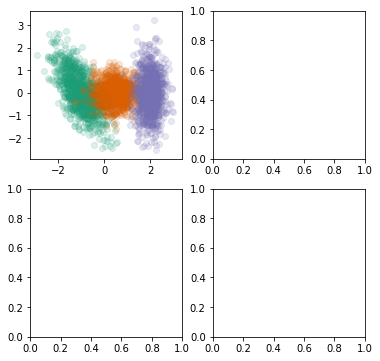

In [97]:
%%time
plot_k_means(3)

#### GMM / k-means in `sklearn`

Clustering algorithms use the common "fit" and "predict" syntax of sklearn.  

While the custom algorithms focused on calculating the cluster centers, the "prediction" regarding points is implicitly wrapped up in the "assign" functions. `sklearn` exposes that functionality more explicitly with `.predict()` methods.

In [98]:
from sklearn.mixture import GaussianMixture
from matplotlib.colors import to_hex, to_rgb
# Maximum of 8 Clusters( color constraint)
def plot_sk_clust(clusters = 3, clust = GaussianMixture):
    def find_hex(p, colors):
        p = p.reshape(-1,1)
        return to_hex(np.sum(p*colors, axis=0))

    #
    # Create figure
    fig, (axs) = plt.subplots(2,2, figsize = (6,6))
    
    # Go thorugh all data sets 
    for ax, df in zip(axs.flatten(), [mv_df, unif_df, mv2_df, mv3_df]):
        
        
        # Pull out point data
        points = df.iloc[:,:2].values
        
        # Give list of colors as RGB
        colors = ["#1b9e77", "#d95f02", "#7570b3","#e7298a","#66a61e","#e6ab02","#a6761d","#666666"][:clusters]
        colors = [np.array(to_rgb(c)) for c in colors]
        colors = np.array(colors)
        
        
        
        ###
        # SKLEARN 
        ###
        
        # Fit Clusters from points
        cl = clust(clusters).fit(points)
        
        
        # Calculate Color values from clusters
        # Note ".predict()" and ".predict_proba()"
        if clust == GaussianMixture:
            probs = cl.predict_proba(points)
            plot_colors = [find_hex(p,colors) for p in probs]
            
        if clust == KMeans:
            probs = cl.predict(points)
            plot_colors = [colors[p] for p in probs]

        ###
        # END SKLEARN
        ###
            
        # Plot points with colors
        ax.scatter(df.x, df.y, label = None, c = plot_colors, alpha = .15)
    # Add super title
    fig.suptitle(clust.__str__(clust).split(".")[-1][:-2] + "; Clusters: " + str(clusters))
    plt.show()

#### Visualizations of clustering with `sklearn`

Below cell may be edited

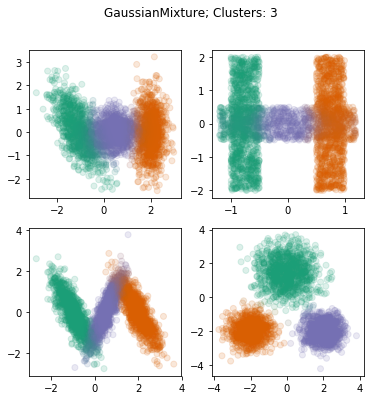

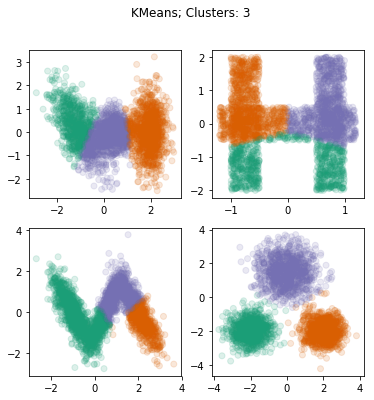

In [99]:
plot_sk_clust(clusters = 3, clust = GaussianMixture)
plot_sk_clust(clusters = 3, clust = KMeans)